In [ ]:
%%file automatedMLRegressor.py
import inspect                                                                  # load inspect module
import warnings                                                                 # load warning module
import numpy as np                                                              # load numerical python
import pandas as pd                                                             # load pandas
from sklearn.preprocessing import Normalizer,normalize,StandardScaler,MinMaxScaler# load all preprocessing modules
from sklearn.linear_model import LinearRegression                               #  linear model - Linear Regression (for regression)
from sklearn.linear_model import LogisticRegression                             #  linear model - Logistic Regression (for classification)
from sklearn.tree import DecisionTreeRegressor                                  # Decision Tree Regression (for regression)
from sklearn.tree import DecisionTreeClassifier                                 # Decision Tree Classifier (for classification)
from sklearn.neighbors import KNeighborsRegressor                               # k-Nearest Neighbors Regressor (for regression)
from sklearn.neighbors import KNeighborsClassifier                              # k-Nearest Neighbors Classifier (for classification)
from sklearn.svm import SVR                                                     # Support Vector Machines - Regressor (for regression)
from sklearn.svm import SVC                                                     # Support Vector Machines - Classifier (for classification)
from sklearn.naive_bayes import GaussianNB                                      # Gaussian Naive Bayes - Classifier (for classification)


class CustomNormalizer(Normalizer):                                             # make normalizer custom class

  ''' norm ('l1','l2' or 'max'): default='l2'. The norm to use to normalize each non
          zero sample (or each non-zero feature if axis is 0).
        axis (0 or 1), default=1. Define axis used to normalize the data along. If 1,
          independently normalize each sample, otherwise (if 0) normalize each feature.
        copybool, default=True. Set to False to perform inplace row normalization and
          avoid a copy (if the input is already a numpy array or a scipy.sparse CSR
          matrix and if axis is 1).
  '''

  def __init__(self,norm:str='l2',axis:int=1,copy:bool=True)->Normalizer:       # make constructor (CustomNormalizer)

    ''' norm ('l1','l2' or 'max'): default='l2'. The norm to use to normalize each non
          zero sample (or each non-zero feature if axis is 0).
        axis (0 or 1), default=1. Define axis used to normalize the data along. If 1,
          independently normalize each sample, otherwise (if 0) normalize each feature.
        copybool, default=True. Set to False to perform inplace row normalization and
          avoid a copy (if the input is already a numpy array or a scipy.sparse CSR
          matrix and if axis is 1).
    '''

    super().__init__(norm=norm,copy=copy)                                       # call parent constructor
    self.norm=norm                                                              # normalize type - 'l1', 'l2' or 'max'
    self.axis=axis                                                              # axis, 0 - feature-wise and 1 - sample wise
    self.copy=copy                                                              # copy - make copy of data or not


  def fit(self,X,y=None)->None:                                                 # define fit method

    ''' Only validates estimator’s parameters. This method allows to:
          (i) validate the estimator’s parameters and
          (ii) be consistent with the scikit-learn transformer API.
    '''

    warnings.warn('Only work feature wise!')                                    # make warn
    return super().fit(X,y)                                                     # call parent fit method


  def transform(self,X,copy=None)->np.array:                                    # define transform

    ''' Scale each non zero row of X to unit norm. '''

    warnings.warn('Only work feature wise!')                                    # make warn
    return super().transform(X,copy)                                            # call parent transform method


  def fit_transform(self,X,y=None,return_norm:bool=False)->np.array:            # define fit transform

      ''' Fit to data, then transform it. Fits transformer to X and y with optional
          parameters fit_params and returns a transformed version of X.
      '''

      return normalize(X,norm=self.norm,axis=self.axis,copy=self.copy,return_norm=return_norm)# define axis wise normalization


class AutoMLRegressor(object):                                                  # make auto ML class for Regression

  ''' Dictionary of regression algorithm as key (string) and value as None.
      Available algorithm are -
        LinearRegression
        DecisionTreeRegressor
        KNeighborsRegressor
        SupportVectorMachineRegressor
      Auto ML class for regression
  '''

  def __init__(self,**kwargs)->object:                                          # define constructor

    ''' Dictionary of regression algorithm as key (string) and value as None.
        Available algorithm are -
          LinearRegression
          DecisionTreeRegressor
          KNeighborsRegressor
          SupportVectorMachineRegressor
        Auto ML class for regression
    '''

    self.algos=dict()                                                           # setup algorithm dictionary
    self.preprocessors={StandardScaler:dict(kwargs=[dict(copy=True,with_mean=True,with_std=True)]),# set preprocessors methods
                        MinMaxScaler:dict(kwargs=[dict(feature_range=(0,1),copy=True,clip=False,)]),
                        CustomNormalizer:dict(kwargs=[dict(norm='l2',axis=1,copy=True),dict(norm='l2',axis=0,copy=True),
                                                      dict(norm='l1',axis=1,copy=True),dict(norm='l1',axis=0,copy=True),
                                                      dict(norm='max',axis=1,copy=True),dict(norm='max',axis=0,copy=True)])}

    for key in kwargs:                                                          # check for each parameter (keyword argument given)
      if isinstance(key,str) and len(key)>=4:                                   # input must be string of length 4 or more
        if (key.casefold() in 'Regressor'.casefold()):                          # if input is "regressor", i.e. all regression methods
          self.algos[LinearRegression()]=dict(hyperparameter=dict(fit_intercept=[True,False]))# setup for linear regression
          self.algos[DecisionTreeRegressor()]=dict(hyperparameter=dict(         # setup for decision tree regressor
              criterion=['squared_error','friedman_mse','absolute_error','poisson'],
              splitter=['best','random'],max_depth=[None,5,7,10,15,30],))
          self.algos[KNeighborsRegressor()]=dict(hyperparameter=dict(n_neighbors=list(range(2,15)),# setup for K-neighbors regressor
              weights=['uniform','distance'],algorithm=['auto','ball_tree','kd_tree','brute'],leaf_size=[7,15,30,60],p=[1,2],))
          self.algos[SVR()]=dict(hyperparameter=dict(kernel=['linear','poly','rbf','sigmoid']))# setup for support vector machines - regressor
        elif (key.casefold() in 'LinearRegression'.casefold()) or (key.casefold() in 'Linear'.casefold()):# if input is "linear regression"
          self.algos[LinearRegression()]=dict(hyperparameter=dict(fit_intercept=[True,False]))# setup for linear regression
        elif key.casefold() in 'DecisionTreeRegressor'.casefold():              # if input is "decision tree regressor"
          self.algos[DecisionTreeRegressor()]=dict(hyperparameter=dict(         # setup for decision tree regressor
               criterion=['squared_error','friedman_mse','absolute_error','poisson'],
                splitter=['best','random'],max_depth=[None,5,7,10,15,30],))
        elif key.casefold() in 'KNeighborsRegressor'.casefold():                # if input is "K-Neighbors Regressor"
          self.algos[KNeighborsRegressor()]=dict(hyperparameter=dict(           # setup for "K-Neighbors Regressor"
              n_neighbors=list(range(2,15)),weights=['uniform','distance'],
              algorithm=['auto','ball_tree','kd_tree','brute'],leaf_size=[7,15,30,60],p=[1,2],))
        elif (key.casefold() in 'SupportVectorMachineRegressor'.casefold()) or (key.casefold() in 'SupportVectorMachine'.casefold()) \
          or (key.casefold() in 'SupportVectorRegressor'.casefold()):           # if input is "Support Vector Regressor"
          self.algos[SVR()]=dict(hyperparameter=dict(kernel=['linear','poly','rbf','sigmoid'],))# setup for "Support Vector Regressor"
        else:                                                                   # if input is invalid, warn user
          warnings.warn(f'NotImplemented: Method not implemented warning! Given method - {key} not implimented or invalid.',category=UserWarning)
      else: raise ValueError(f'Invalid key - {key}. Given arguments must be string of length four or more.')# if key is invalid, warn user


  def __repr__(self)->str:                                                      # object value

    ''' Return the canonical string representation of the object '''

    return '< Automated Machine Learning Regressor >'


  def __str__(self)->str:                                                       # return string

    ''' Return the canonical string representation of the object '''

    return self.__repr__()


  def get_params(self)->dict:                                                   # method to get class parameters

    ''' Method to get class parameters as dictionary. '''

    return self.__dict__                                                        # return dictionary of parameters


  def set_params(self,**kwargs)->None:                                          # method to set class parameters

    ''' Method to get class parameters from dictionary.
        kwargs (dict) : dictionary of parameters.
    '''

    for key,value in kwargs.items(): setattr(self,key,value)                    # set attribute form dictionary


  def get_info(self,algorithm:str,level:str='__doc__')->None:                   # method to get info on given algorithm

    ''' Method to get info on given algorithm by its name.
          algorithm (string): name of algorithm.
            LinearRegression
            DecisionTreeRegressor
            KNeighborsRegressor
            SupportVectorMachineRegressor
            StandardScaler
            MinMaxScaler
            Normalizer
          level (string): '__doc__' or 'all', default 'all'. '__doc__' if want only doc
            string, 'all' if want all full info
    '''

    all_algos={'LinearRegression'.casefold():LinearRegression,'DecisionTreeRegressor'.casefold():DecisionTreeRegressor,# all algorithms
               'KNeighborsRegressor'.casefold():KNeighborsRegressor,'SupportVectorMachineRegressor'.casefold():SVR,
               'StandardScaler'.casefold():StandardScaler,'MinMaxScaler'.casefold():Normalizer}
    if not (isinstance(level,str) or level.casefold()=='__doc__'.casefold() or level.casefold()=='all'.casefold()):# check level argument
      raise ValueError(f'`level` must be one of "__doc__" or "all". But got level -> {level}.')# raise value error
    if isinstance(algorithm,str) and algorithm.casefold() in all_algos:         # check algorithm is present or not
      if level.casefold()=='__doc__': print(all_algos[algorithm.casefold()].__dict__['__doc__'])# if only docs string have to be printed
      else:                                                                     # print all info
        for key,value in all_algos[algorithm.casefold()].__dict__.items():      # get each key and value in doc
          print(key,':\n\t',value)
    else:                                                                       # raise value error if algorithm not found
      warnings.warn(f'Invalid algorithm -> {algorithm}. It must be one of - \n\tLinearRegression\n\tDecisionTreeRegressor\n\tKNeighborsRegressor'\
                    '\n\tSupportVectorMachineRegressor\n\tSupportVectorMachineRegressor\n\tSupportVectorMachineRegressor\n\t'\
                    'SupportVectorMachineRegressor\n\tSupportVectorMachineRegressor\n\tStandardScaler\n\tMinMaxScaler\n\tNormalizer')


  def set_hyperparmeter(self,algorithm,hyperparameters:dict,update:bool=True)->None:# method to set regression algorithm hyperparameters

    ''' Method to set regression algorithm hyperparameters.
        algorithm (class | string) : algorithm name (string) or class.
        hyperparameters (dict) : dictionary of hyper-parameters of that class
        update (bool): True | False, default True. To update hyperparameters
          dictionary or change.
    '''

    if not (isinstance(algorithm,str) or inspect.isclass(algorithm)):           # if algorithm is (name as) string or not class
      raise ValueError(f'Invalid value of algorithm! algorithm must be instance of string or scikit-learn regression class, but got -> {type(algorithm)}')
    if not isinstance(hyperparameters,dict):                                    # if hyperparameters is not dictionary
      raise ValueError(f'Invalid value of hyperparameters! hyperparameters must be instance of dictionary, but got -> {type(hyperparameters)}')
    if not isinstance(update,bool):                                             # if update is not bool type
      raise ValueError(f'Invalid value of update! hyperparameters must be instance of bool, but got -> {type(update)}')
    for preprocessor in self.preprocessors:                                     # take a preprocessors
      if algorithm==str(algo) or (inspect.isclass(algorithm) and isinstance(algo,algorithm)):# if algorithm is that which has to update or change
        if update: self.algos[algo]['hyperparameter'].update(hyperparameters)   # update hyperparameters (if stated)
        else: self.algos[algo]['hyperparameter']=hyperparameters                # change hyperparameters (if stated)
        break                                                                   # make loop break
    else:                                                                       # raise error if algorithm name is invalid
      raise ValueError(f'In value algorithim give. Got -> {algorithm} but it must be one of {self.algos.keys()}, string or class.')


  def set_preprocessing_kwargs(self,preprocessing,kwargs,append:bool=True)->None:# method to update / change kwargs

    ''' Method to update / change kwargs -
         preprocessing : preprocessing class name (string) or class
         kwargs : list of dictionary (kwargs) for preprocessing or dictionary of kwargs.
          dictionary of kwargs if append is True, else list of dictionary (kwargs) for
          preprocessing.
         append (bool): True | False. Default True.
    '''

    if not (isinstance(preprocessing,str) or inspect.isclass(preprocessing)):   # if preprocessing is (name as) string or not class
      raise ValueError(f'Invalid value of preprocessing! preprocessing must be instance of string or sklear.prepocessing class, but got -> {type(preprocessing)}')
    if not isinstance(append,bool):                                             # if append is not bool type
      raise ValueError(f'Invalid value of append! hyperparameters must be instance of bool, but got -> {type(append)}')
    if (append==True) and (not isinstance(kwargs,dict)):                        # if kwargs is not dictionary, when append true
      raise ValueError(f'Invalid value of kwargs! kwargs must be instance of dictionary, but got -> {type(kwargs)}, when append=True.')
    elif (append==False) and (not isinstance(kwargs,list)):                     # if kwargs is not list, when append false
      raise ValueError(f'Invalid value of kwargs! kwargs must be list of dictionary, but got -> {type(kwargs)}, when append=False.')

    for preprocessor in self.preprocessors:                                     # take a algorithm
      if preprocessing==str(preprocessor) or (inspect.isclass(preprocessing) and isinstance(preprocessor,preprocessing)):# if preprocessor is that which has to update or change
        if append: self.preprocessors[preprocessor]['hyperparameter'].append(kwargs)# apppend hyperparameters (if stated)
        else: self.preprocessors[preprocessor]['hyperparameter']=kwargs         # change hyperparameters (if stated)
        break                                                                   # make loop break
    else:                                                                       # raise error if algorithm name is invalid
      raise ValueError(f'In value algorithim give. Got -> {preprocessing} but it must be one of {self.preprocessors.keys()}, string or class.')


  def fit(self,X,y,gridSearchCV_parms:dict=dict(scoring=None,cv=None))->dict:   # define fit method

    ''' Exhaustive search over specified parameter values for an estimator. The parameters
        of the estimator used to apply these methods are optimized by cross-validated
        grid-search over a parameter grid. Run fit with all sets of parameters.
        X (pandas.DataFrame | numpy.ndarray) : X (inputs), must be 2-dimensional.
        y (numpy.ndarray) : y (outputs).
        gridSearchCV_parms (dict) : GridSearchCV parameters. Default dict(scoring = None,
          cv = None).
    '''

    if not (isinstance(X,pd.core.frame.DataFrame) or isinstance(X,np.ndarray)): # check `X` must be numpy.ndarray or pandas.DataFrame object
      raise ValueError(f'`X` must be instance of numpy.ndarray or pandas.DataFrame, but given `{type(X)}`')
    elif not (X.ndim==2):                                                       # check for dimensionality of `X`, must be 2
      raise ValueError(f'`X` must be 2-dimensional, but got -> `{X.ndim}`. Try to reshape it using X.reshape(-1,1) or X.reshape(1,-1).')
    if not (isinstance(y,pd.core.frame.DataFrame) or isinstance(y,np.ndarray) or isinstance(y,pd.core.frame.Series)):# check `y` must be numpy.ndarray or pandas.DataFrame object
      raise ValueError(f'`y` must be instance of numpy.ndarray or pandas.Series, but given `{type(y)}`')
    elif not (y.ndim==1 or y.ndim==2):                                          # check for dimensionality of `y`, must be 2 or 1
      raise ValueError(f'`y` must be 2-dimensional or 1-dimensional, but got -> `{y.ndim}`. Try to reshape it using reshape method.')

    for algo,algo_data in self.algos.items():                                   # get algorithm one by one, from dictionary and its result
      algo_data['results'],algo_data['best_score'],algo_data['best_estimator'],algo_data['preprocessor'],algo_data['preprocessor_kwarg']=list(),list(),list(),list(),list()
      for preprocessor,kwargs_dict in self.preprocessors.items():               # get preprocessors (class) and its list of arguments (dictionary)
        for kwarg in kwargs_dict['kwargs']:                                     # get argument (dictionary) for list of arguments
          model=GridSearchCV(algo,algo_data['hyperparameter'],**gridSearchCV_parms)# make "GridSearchCV" model with given hyperparameter (model)
          model.fit(preprocessor(**kwarg).fit_transform(X),y)                   # make model train with given preprocessing
          algo_data['results'].append(model.cv_results_)                        # store cv results
          algo_data['best_score'].append(model.best_score_)                     # store best score
          algo_data['best_estimator'].append(model.best_estimator_)             # store best estimator
          algo_data['preprocessor'].append(preprocessor.__name__)               # store preprocessing name
          algo_data['preprocessor_kwarg'].append(kwarg)                         # store preprocessing hyperparameters

    return self.algos                                                           # make return all

Writing automatedMLRegressor.py


In [ ]:
from automatedMLRegressor import AutoMLRegressor
autoRegressor=AutoMLRegressor(linear=None)


# Questions (Problem Set 1) ----

Q.1. Write a python code to read below created file (integers.txt), and find the mean of all numbers in file **without using (import) any module**.

```python
%%file integers.txt
[5, 6, 8, 7, 8, 9, 2, 3,
 1, 9, 2, 7, 3, 2, 4, 6, 2]
```

Q.2. Write a python code to find / replica standard deviation for a given numpy array **(without using numpy.std)**.

Q.3. Write a python code to randomly generate numpy array of 3 rows and 4 columns from standard normal probability distribution. Find the difference between its mean and mean of the transpose of generated array.

Q.4. Write a python function to return mean of all odd and even number for a given array of integers as tuple **(the faster the code is, more it is appreciated)**.  




In [ ]:
# Timer ------------------------------------------------------------------------
from time import time,sleep
for second in range(60*60,0,-1): print('\r',end='');print(f'Minutes left:{round(second/60,2)} or Seconds left:{second}',end='');sleep(1)

In [ ]:
# Question 1
with open('integers.txt',mode='r') as file_object:
  numbers=[float(value) for value in file_object.read().replace('[','').replace(']','').replace('\n','').split(',')]
print('Mean:',sum(numbers)/len(numbers))

In [ ]:
# Question 2
import numpy as np
def std(array:np.ndarray)->float:
  #return np.sqrt(np.sum(np.square(array-array.mean()))/(array.size-1))
  return np.sqrt(np.mean(np.square(array-array.mean())))

In [ ]:
# Question 3
import numpy as np
random_array=np.random.normal(loc=0.0,scale=1.0,size=(3,4))
random_array.T.mean()-random_array.mean()

In [ ]:
# Question 4
import numpy as np
def customMean(array:np.ndarray,round2:int=3)->tuple:
  return round(array[array%2==0].mean(),round2),round(array[array%2==1].mean(),round2)

# Questions (Problem Set 2) ----

Q.1 Write a python code to load to excute following tasks -
1. Generate a random numpy array of shape 100 rows and 2 columns from nornal probability distribution of mean 1 and standard deviation 0.5.
2. Make a pandas DataFrame from randomly generated array in step 1. Make print the stats (mean, standard deviation, minimum, maximum, median, first quartile and third quartile) of the data (all as one single DataFrame).
3. Make plot the box and whisker plot for all columns.
4. Are both columns are statistically similar? Give reason in support of your answer.

Q.2 Write a python code to load to excute following tasks -
1. Generate sorted 100 random number between 0 and 1 (as 1-dimesional numpy array).
2. Using the linear equation of line `y = mx + c`, calculate the value of y for slope 32° and interept at 2.3. Add random noise to data of 100 value randomly generated from normal distribution of mean 0 and standard deviation 0.05
3. Make a regression model using scikit-learn's linear regression model (sklearn.linear_model.LinearRegression). Find the difference between the actual coefficient (slope) and calculated coefficient (by your linear model). Do same for intercept also.

Q.3. Write a python code to load to excute following tasks -

1. Using scikit-learn's toy datasets load breast cancer dataset. Make explain the stats and features importance (as best as you can).
2. Make a machine learning model (from sklearn.linear_model), as best you can. Evaluate the model on 33% test size on sklearn.metrics (error or accuracy) (Hint: One can use any preprocessing method if need, to achieve best results).

For your help data info is given below -

```
Load and return the breast cancer wisconsin dataset (classification).

The breast cancer dataset is a classic and very easy binary classification dataset.
```
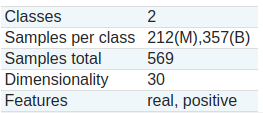

In [ ]:
# Timer ------------------------------------------------------------------------
from time import time,sleep
for second in range(60*60,0,-1): print('\r',end='');print(f'Minutes left:{round(second/60,2)} or Seconds left:{second}',end='');sleep(1)

Minutes left:0.02 or Seconds left:1